## **IMPORTS**|

In [53]:
#IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from scipy.signal import medfilt2d

In [54]:
fN = "CSE483 Sp24 Project Test Cases/" #folderName
img_array = [fN+'01-Getting-started.png',fN+'02-Matsawar-3edel-ya3am.png', fN+'03-Leffy-bina-ya-donya.png',
             fN+'04-Black-mirror.png',fN+'05-Caesar-cipher.png', fN+'06-Railfence-cipher.png',
             fN+'07-THE-MIGHTY-FINGER.png', fN+'08-Compresso-Espresso.png', fN+'09-My-phone-fell-while-taking-this-one-...-or-did-it.png', fN+'10-Gone-With-The-Wind.png', fN+'11-weewooweewooweewoo.png',
             fN+'12-mal7-w-felfel.png', fN+'13-2el-noor-2ata3.png',fN+'14-BANANAAA!!!.png',
             fN+'15-beast-mode-computer-vision-(this-one-is-from-wikipedia).jpg',
             fN+'16-V3-QR-Code...-can-you-do-it.png']

TEST_CASE = 7
img_address = img_array[TEST_CASE]

## *PREPROCESSING*

In [55]:
def median_filter(img):
    median = cv2.medianBlur(img, 21)
    return median

def smoothing_filter(img):

    return 0

def constrast_stretching(gray):
    # Calculate the minimum and maximum pixel values
    min_val = np.min(gray)
    max_val = np.max(gray)

    # Define the new minimum and maximum values for contrast stretching
    new_min = 0
    new_max = 255

    # Apply contrast stretching
    stretched_image = ((gray - min_val) / (max_val - min_val)) * (new_max - new_min) + new_min

    # Convert the image back to uint8 format
    stretched_image = np.uint8(stretched_image)
    return stretched_image


def brighten_filter(img_gray):
    brightened_img = [pixel if (pixel >= 128) else pixel + 128 for pixel in img_gray.ravel()]
    brightened_img_reshaped = np.reshape(brightened_img, img_gray.shape)
    return brightened_img_reshaped

def rotate_img(img):

    # Rotate the image
    rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return rotated_img

def show_histogram(img):
    plt.figure(figsize=(9,8))
    plt.hist(img.ravel(), bins=256)

def sharpening_filter(img_gray):
    image_float32 = np.float32(img_gray)
    blurred = cv2.GaussianBlur(img_gray, (15, 15), 0)
    blurred_float32 = np.float32(blurred)

    # Calculate the unsharp mask (original image - blurred image)
    unsharp_mask = cv2.subtract(image_float32, blurred_float32)

    # Add the unsharp mask to the original image to sharpen it
    sharpened = cv2.add(image_float32, unsharp_mask)
    sharpened = np.clip(sharpened, 0, 255)  # Clip values to 0-255 range
    sharpened = np.uint8(sharpened)
    return sharpened

def opening_filter(img):
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)))
    # plt.imshow(thresh1, cmap="grey")

    return closed_img

def get_contours(img):
    #img taken into the contours must be binarized (applying greyscale then threshold) for better accuracy

    ## *object to be found should be white and background should be black* ##

    # Find contours in the binary image
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area (assuming it's the outer frame of the QR code)
    largest_contour = max(contours, key=cv2.contourArea)
    # Get the bounding (corner points) of the rectangle of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding rectangle to Extract the QR code region
    qr_code_frame = img[y:y+h, x:x+w]

    # Straightening into a square (assuming the frame is already rectangular)
    # Find the longer side of the rectangle
    if w > h:
        max_dim = w
    else:
        max_dim = h

    # Create a square image with dimensions equal to the maximum dimension
    square_img = np.zeros((max_dim, max_dim), dtype=np.uint8)
    # Calculate the position to paste the rectangle in the center of the square image
    x_pos = (max_dim - w) // 2
    y_pos = (max_dim - h) // 2
    # Paste the rectangle onto the square image
    square_img[y_pos:y_pos+h, x_pos:x_pos+w] = qr_code_frame
    return square_img

def invert_qr(img):
    inverted_img = cv2.bitwise_not(img)
    return inverted_img

def adaptive_threshold(img):
    adptv_threshed_img = cv2.adaptiveThreshold(
    src=img,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # read: https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gaa42a3e6ef26247da787bf34030ed772c
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=111,  # NxN block size (odd) to perform adaptive threshold on
    C=5  # Constant subtracted from the mean or weighted mean
    )

    return adptv_threshed_img


def flip_image(img):
    img = cv2.flip(img,1)
    return img

def fourier(image):
    dft_img = np.fft.fft2(image)
    dft_img_shift = np.fft.fftshift(dft_img)

    return dft_img_shift

def histogram_equalizer(img):
    equalized_img = cv2.equalizeHist(img)
    return equalized_img

def shift_image(image, dx, dy):
    shifted_image = np.roll(image, dy, axis=0)  # Shift rows
    shifted_image = np.roll(shifted_image, dx, axis=1)  # Shift columns
    return shifted_image

def replicate_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_REPLICATE)

def zero_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=0)

def mirror_padding(image, padding_size):
    return cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_REFLECT)

def straighten_image(image):
    # Apply edge detection or any other suitable method to detect edges
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Apply Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 127)
    print(lines)
    # Calculate rotation angle
    # Calculate rotation angle
    total_angle = 0.0
    if lines is not None:
        for line in lines:
            rho, theta = line[0]  # Extract rho and theta from the current line
            total_angle += np.degrees(theta)
        angle = total_angle / len(lines)


    # Rotate the image
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image

def binary_threshold(img, threshold):
    _, thresholded_image = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return thresholded_image


## *Filter functions*

In [56]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx,cy), radius, (255,255,255), -1).astype(np.uint8)

def try_lowpass(dft_img, limit, gaussian: bool = False):
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21,21), 0)
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    # Step 3: Convert back to spatial domain
    f_ishift = np.fft.ifftshift(dft_img_shifted_lowpass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def try_highpass(dft_img, limit, gaussian: bool = False, keep_dc: bool = False):
    mask = ~give_me_circle_mask_nowww(dft_img.shape, limit)
    if (gaussian):
        mask = cv2.GaussianBlur(mask, (21,21), 0)
    if (keep_dc):
        mask[dft_img.shape[0]//2, dft_img.shape[1]//2] = 255
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_highpass = np.multiply(dft_img_shifted, mask)
    # Step 3: Convert back to spatial domain
    f_ishift = np.fft.ifftshift(dft_img_shifted_highpass)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize pixel values to range [0, 255]
    img_back = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return img_back

def plot_shifted_fft_and_ifft(dft_img_shifted):
    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted))
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
    ax1.set(yticks=[0, img.shape[0]//2, img.shape[0] - 1], yticklabels=[-img.shape[0]//2, 0, img.shape[0]//2 - 1]);
    ax1.set(xticks=[0, img.shape[1]//2, img.shape[1] - 1], xticklabels=[-img.shape[1]//2, 0, img.shape[1]//2 - 1]);
    ax1.imshow(np.abs(dft_img_shifted)**0.1, cmap = 'gray');
    ax2.imshow(np.abs(img), cmap = 'gray')
    return dft_img_shifted

In [57]:
def biggestContour(contours):
    biggest = None
    second_biggest = None
    max_area = 0
    second_max_area = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) >= 4:
                if area > max_area:
                    second_biggest = biggest
                    second_max_area = max_area
                    biggest = approx
                    max_area = area
                elif area > second_max_area:
                    second_biggest = approx
                    second_max_area = area

    return biggest, second_biggest, max_area, second_max_area

def reorder(myPoints):
    myPoints=myPoints.reshape((4,2))
    myPointsNew=np.zeros((4,1,2),dtype=np.int32)
    add=myPoints.sum(1)
    myPointsNew[0]=myPoints[np.argmin(add)]
    myPointsNew[3]=myPoints[np.argmax(add)]
    diff=np.diff(myPoints,axis=1)
    myPointsNew[1]=myPoints[np.argmin(diff)]
    myPointsNew[2]=myPoints[np.argmax(diff)]
    return myPointsNew


### Finding the placement boxes contours

Bounding Box 1: (x=659, y=43)


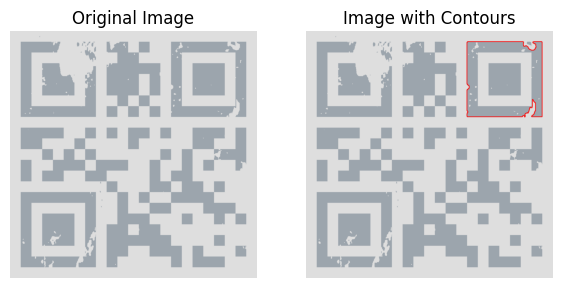

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7))
RotateFlag = False
# Load the image containing the QR code
image = cv2.imread(img_address)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform edge detection using Canny
edges = cv2.Canny(blurred, 50, 150)

# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour(s) by area
max_area = max(cv2.contourArea(contour) for contour in contours)
largest_contours = [contour for contour in contours if cv2.contourArea(contour) > 0.9 * max_area]
# List to store the coordinates of bounding boxes
bounding_box_coordinates = []

# Get bounding box coordinates for the largest contours
for contour in largest_contours:
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)
    # Append the coordinates of the top-left corner (x, y) to the list
    bounding_box_coordinates.append((x, y))

# Check if the specified coordinates are present in any of the bounding boxes
if any((x == 659 and y == 659) for x, y in bounding_box_coordinates):
    # Rotate the image by 180 degrees
    RotateFlag = True

# Print the coordinates of the bounding boxes
for i, (x, y) in enumerate(bounding_box_coordinates):
    print(f"Bounding Box {i + 1}: (x={x}, y={y})")
# Create a copy of the original image to draw the largest contour on
image_with_contours = image.copy()

# Draw the largest contour(s) with a red border
cv2.drawContours(image_with_contours, largest_contours, -1, (0, 0, 255), 2)

# Convert BGR image to RGB for displaying with matplotlib
image_with_contours_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

# Plot the images side by side

# Plot the original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

if RotateFlag == True:
    # Plot the image with contours
    axes[1].imshow(image_with_contours_rgb)
    axes[1].set_title('Image with Contours after rotations')
    axes[1].axis('off')
else:
        # Plot the image with contours
    axes[1].imshow(image_with_contours_rgb)
    axes[1].set_title('Image with Contours')
    axes[1].axis('off')
plt.show()

#### **Importing image and binarizing (making it either 0 or 255)**

(-0.5, 1011.5, 1011.5, -0.5)

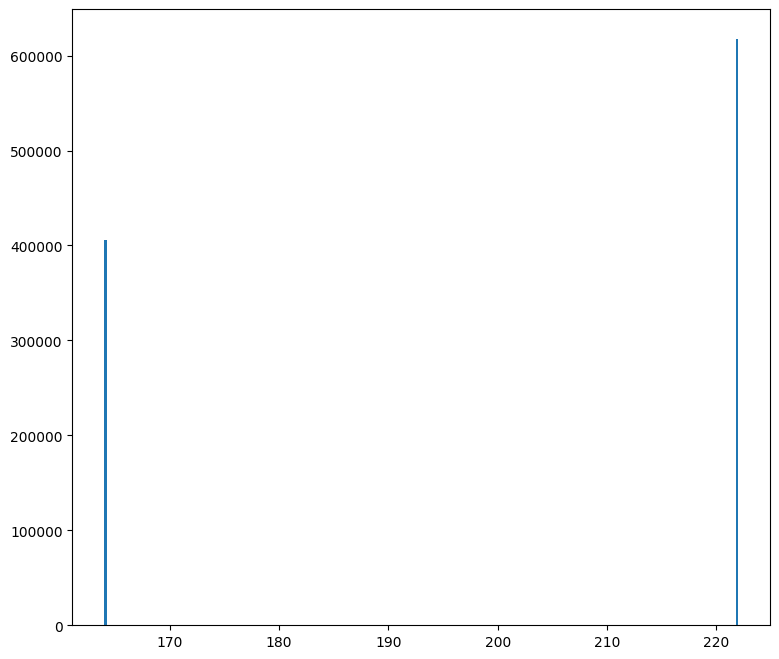

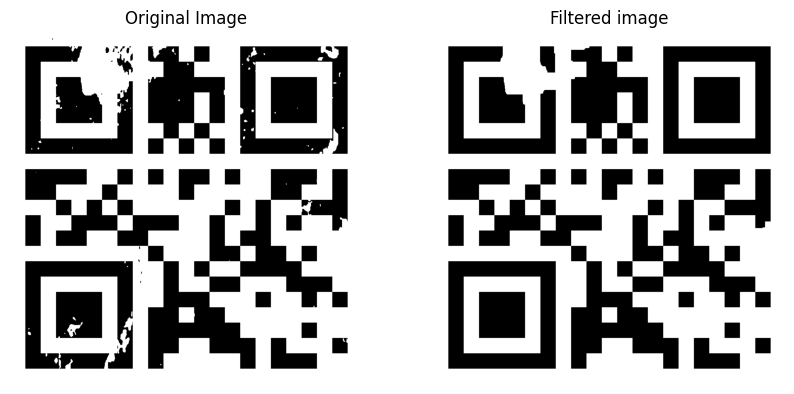

In [59]:
image = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)

img = cv2.imread(img_address, cv2.IMREAD_GRAYSCALE)
# img = cv2.GaussianBlur(img, (5, 5), 1)  # makes image blur
# img = cv2.Canny(img, 10, 50)  # makes image canny
test_case = TEST_CASE

if RotateFlag == True:
   img = cv2.rotate(image, cv2.ROTATE_180)

# ******************************************************************************* #

if test_case==1:
    img = straighten_image(img)

# ******************************************************************************* #

elif test_case == 3: # 04-Black-mirror
    img = flip_image(img)
    equalized_img = histogram_equalizer(img)
    _, threshold_image = cv2.threshold(equalized_img, 128, 255, cv2.THRESH_BINARY)
    # img = get_contours(threshold_image)
    img = invert_qr(threshold_image)

# ******************************************************************************* #
elif test_case == 6:
    img = adaptive_threshold(img)

# ******************************************************************************* #
elif test_case == 7:
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    img = cv2.erode(img, square_se)
    img = cv2.dilate(img, square_se)
    img = cv2.dilate(img, square_se)
    img = cv2.erode(img, square_se)
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (41, 41))
    img = cv2.erode(img, square_se)
    img = cv2.dilate(img, square_se)
    show_histogram(img)
    _, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
    # img = adaptive_threshold(img)

    # img[mask_binary == 255] = image1[mask_binary == 255]

# ******************************************************************************* #

elif test_case == 8:
    img = constrast_stretching(img)
    img = sharpening_filter(img)

# ******************************************************************************* #

elif test_case == 9:
    img = constrast_stretching(img)
    img = histogram_equalizer(img)
    # img = brighten_filter(img,10)

# ******************************************************************************* #

elif test_case == 10:
    img = cv2.medianBlur(image, 5)
    dft_img = np.fft.fft2(img)
    high_pass = try_highpass(dft_img, 30, gaussian=True, keep_dc=True)
    # img = adaptive_threshold(img)

    _, threshold_image = cv2.threshold(high_pass, 72, 255, cv2.THRESH_BINARY)
    img = threshold_image
    # img = histogram_equalizer(img)
    # show_histogram(img)
   # img = adaptive_threshold(img)

# ******************************************************************************* #

elif test_case == 11:
    show_histogram(img)
    # img_threshold = binary_threshold(img, 128)
    # inverted = invert_qr(img)
    # median_filtered = median_filter(img)
    # show_histogram(median_filtered)
    # # creating a mask for the salt&pepper
    # # mask = np.zeros_like(median_filtered)
    # # mask[median_filtered < 5]   = 255
    # # mask[median_filtered > 250] = 255
    # # img = cv2.inpaint(median_filtered,mask,3,cv2.INPAINT_TELEA)
    #
    # show_histogram(img)
    img = cv2.medianBlur(img, 11)
    img = adaptive_threshold(img)
    # img
    # img_not = median_filter(img)
    # noise = img_not * inverted_img
    # img = img - noise - noise
    # img = adaptive_threshold(median_img)

    # img = try_highpass(dft_img, 20, gaussian=True, keep_dc=True)

    # img = dilated_mask
   # _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

# ******************************************************************************* #

elif test_case == 12:
    img = adaptive_threshold(img)
    square_se = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))

    square_se_canvas = np.zeros_like(img)
    square_se_canvas[-45:-24, -45:-24] = square_se
    median_box_thresholded = np.array(cv2.threshold(img, 150, 1, cv2.THRESH_BINARY_INV)[1], dtype="uint8")
    eroded_median_box_thresholded = cv2.erode(median_box_thresholded, square_se)
    dilated_after_eroded_median_box_thresholded = cv2.dilate(eroded_median_box_thresholded, square_se)
    mask = dilated_after_eroded_median_box_thresholded  # Just giving it an alias cause the name got too long
    dilated_mask = cv2.dilate(mask, square_se)
    eroded_after_dilated_mask = cv2.erode(dilated_mask, square_se)

# ******************************************************************************* #

elif test_case == 13:
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    # Find contours in the edges image
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Iterate over each contour
    for contour in contours:
        # Approximate the contour to a polygon
        polygon = cv2.approxPolyDP(contour, 1.5 * cv2.arcLength(contour, True), True)
        # Check if the polygon has 4 sides
        # print(type(len))
        if len(polygon) == 4:
            # Draw the rectangle on the image
            x, y, w, h = cv2.boundingRect(polygon)
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 0), 3)

# ******************************************************************************* #

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(img, cmap = 'gray')
axes[1].set_title('Filtered image')
axes[1].axis('off')


In [60]:
# image = cv2.imread(img_address)

# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#
# img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
# hist = cv2.calcHist([img_gray],[0],None,[256],[0,256])
#
# black_pixels = hist[0:128]
#
# # Find the intensity value with the maximum count (peak of the histogram)
# peak_intensity = np.argmax(black_pixels)
# Equalized_image = False
# # Check if the count at the peak is greater than a certain threshold
# print(hist[peak_intensity])
# if hist[peak_intensity] > 500000:
#     print("Equalized")
#     Equalized_image = True
#     img = cv2.equalizeHist(img_gray)
#

## Use quiet zone to detect code area
Simply go through white rows and columns until you find the first black pixel from the left, from the right, from the top, and from the bottom.

In [61]:
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break

print("start row: ", start_row, ", end row: ", end_row, ", start col: ", start_col, ", end col: ", end_col)
#get_qr_without_quiet_zone(img, start_row, end_row, start_col, end_col)

start row:  44 , end row:  968 , start col:  44 , end col:  968


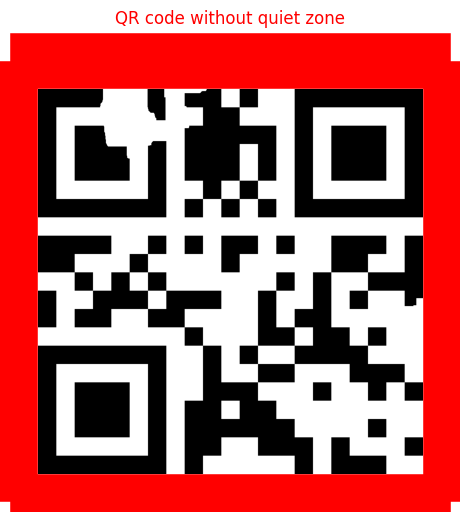

In [62]:
qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
fig.get_axes()[0].spines[:].set_color('red')
fig.get_axes()[0].spines[:].set_linewidth(40)
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y=1.15, color='red')
plt.imshow(qr_no_quiet_zone, cmap='gray')
#determine_grid_size(qr_no_quiet_zone)

## Use locator boxes to determine grid size
Since we know that the topleft pixel should be the border of the locator box, and that its size should be 7×7, we can determine the grid cell size by dividing its size in pixels by 7. How to get its size? It is a constant black row of pixels followed by one white cell. A simple for loop can get it done.

Grid cell size:  22
(924, 924)
(42, 42, 22, 22)


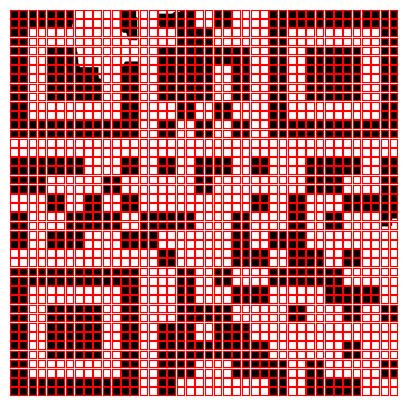

In [63]:
size = 0
for pixel in qr_no_quiet_zone[0]:
    if (pixel != 0): break
    size += 1
grid_cell_size = round(size / 7)
print("Grid cell size: ", grid_cell_size)
if grid_cell_size!= 0:
    grid_cells_num = round(qr_no_quiet_zone.shape[0] / grid_cell_size)
else:
    print("incorrect Qr code detected")
print(qr_no_quiet_zone.shape)
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')
# converting_grid_into_numbers(grid_cells_num, qr_cells)

## Convert grid tiles to numeric values

In [64]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(qr_cells):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)
print(qr_cells_numeric)
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


### Error correction level

In [65]:
print(qr_cells_numeric[8])

[0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0
 0 1 1 0 0]


In [66]:
# The first two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not (c)) for c in qr_cells_numeric[8, 0:2]]
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)
# mask_pattern(qr_cells_numeric)

[1, 1]


### Mask pattern

In [67]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
mask = [int(not (c)) for c in qr_cells_numeric[8, 2:5]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)
# format_error_correction(qr_cells_numeric)
# plt.show()

001


### Format error correction

In [68]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(not (c)) for c in fec]
print(fec)

[1, 1, 0, 0, 0, 0, 0, 0, 1, 1]


In [69]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [0, 0, 1] [1, 1, 0, 0, 0, 0, 0, 0, 1, 1]


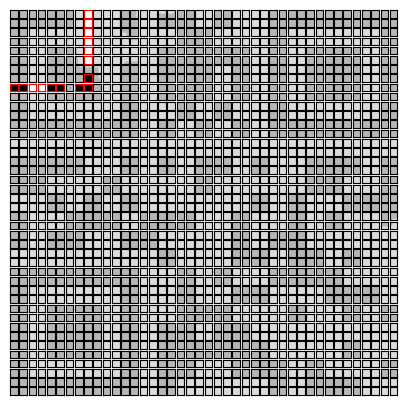

In [70]:
# Let's cross-check with our example
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i == 8 and j <= 8) or (i <= 8 and j == 8):
            if (i != 6) and (j != 6):
                col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
                col.spines[:].set_color('red')
                continue
        col.imshow(qr_cells[i][j], cmap="gray", vmin=-1275, vmax=510)
    # print(ecl, mask, fec)

In [71]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [1, 0, 0] [1, 1, 0, 0, 0, 1, 0, 0, 0, 1]


## Data extraction


In [72]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding

In [73]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
print(enc)

[0, 0, 0, 0]


### Data length

In [74]:
length = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
print(length)

[1, 1, 1, 1, 0, 0, 0, 0]


### Data extraction

In [75]:
data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-10, grid_cells_num-11, DOWN],
    [grid_cells_num-6, grid_cells_num-11, DOWN],
    # Hmm..? I actually don't know how to proceed now lol
]

ans = ''
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    if bit_string[:4] == "0000":
        print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
        break
    ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
    print(f'{bit_string} = {ans[-1]}')

print(f'\nDecoded string: {ans}')

0000 = 0 (NULL TERMINATOR)

Decoded string: 
